# Fitting to get the powder average coefficients.
After fitting CF eigenvalues to neutron data the susceptibility as calculated by PCF is orders of magnitude off of our measurements. Turns out PCF does powder averaging by summing in all three directions then dividing by 3. This is a commonly used tool.
However, with our systems g-tensor the g<sub>xx</sub> = g<sub>yy</sub> > g<sub>zz</sub> by almost 3 times. 

[This paper](https://arxiv.org/ftp/arxiv/papers/1312/1312.2401.pdf) demonstrates that 1/3 factor may not be true for all systems.

I decide to fit predicted magnetization to measurements by allowing the coefficients for each magnetization direction to vary. After this magnetization fitting we gather the prefactors that properly scales PCF's prediction.

In [25]:
import sys
sys.path.append('..')
from JensenTools import *
import seaborn as sns
sns.set()

## Declare important variables.

In [26]:
# Define important things
#####################################################################################################################################################################
comp = 'Sr2PrO4'
who = 'Arun'
ion = 'Ce3+'
LS_on = True
per = 'spin'
molweight = molweight[comp]
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
#####################################################################################################################################################################

## LMFIT Model for fitting coefficients of powder averaging

In [27]:
# Function to be made into an LMFIT model.
def magFit(Pr,a,c, HTes, **kwargs ):
    mag = []
    if kwargs['LS_on']:
        for i in HTes:
            mag.append(a*Pr.magnetization(Temp = Temp, Field = [i, 0, 0])[0] + a*Pr.magnetization(Temp = Temp, Field = [0, i, 0])[1] + c*Pr.magnetization(Temp = Temp, Field = [0, 0, i])[2])
    else:
        for i in HTes:
            mag.append(a*Pr.magnetization(Temp = Temp, Field = [i, 0, 0], ion = ion)[0] + a*Pr.magnetization(Temp = Temp, Field = [0, i, 0], ion = ion)[1] + c*Pr.magnetization(Temp = Temp, Field = [0, 0, i], ion = ion)[2])
    return -1*np.array(mag)

## Best fit Stevens coefficients from fitting to energy

In [28]:
#Best Fit LS
#####################################################################################################################################################################
if LS_on:
	B40  =  -0.6568663783690575
	B60  =  -0.02328250024945387
	LS  =  100.00007580463522
	B44  =  -3.1415463304732714
	B64  =  0.504906552605772
	B20  =  0.4858075931009187
#####################################################################################################################################################################

# Best Fit J
#####################################################################################################################################################################
if not LS_on:
	# # Red Chi = ~.01
	B40  =  -0.5572886105373519
	B60  =  0.4673
	B44  =  -3.0946858584804335
	B64  =  -9.8133
	B20  =  12.606195720794622
#####################################################################################################################################################################

# Create Pr CFLevels object using the best fit coefficients.
#####################################################################################################################################################################
stev = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }
#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=LS)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = ion)
	Pr.diagonalize()
#####################################################################################################################################################################

## Loading M vs H measured data and choosing a temperature run.

In [29]:
# Loading data for M vs H
#####################################################################################################################################################################
saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MHDir = getSaveDir('m',comp = comp, dataType = 'MH') #MvsH data

runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MHdata = {}
for i in runs:
    M, H, Err, mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = normalize(M,mass,molweight, per)
    Err = normalize(Err,mass,molweight, per)
    MHdata[T] = [M,H,Err,mass,i]
#####################################################################################################################################################################


# Choosing 20K run
T = '20K'
Temp = getTemp(MHdata[T][-1], who = who)
M, H, Err, mass, filename = MHdata[T]

MBohr = emuToBohr2(M)
HTes = oeToTesla(H)

## Fit the model to data allowing powder average coefficients to vary.

In [30]:
# Make LMFIT model and fit
# Create stevens coefficients dictionary from fitted parameters
#####################################################################################################################################################################
magModel = Model(magFit, independent_vars = ['HTes', 'Pr'])
params = magModel.make_params()

# Bounded
# params['a'].set(value = 1/3, min = .0001, max = 1)
# params['b'].set(value = 1/3, min = .0001, max = 1)
# params['c'].set(value = 1/3, min = .001, max = 1)

params['a'].set(value = 1/3, min = .0001, max = 1)
params.add('c', expr = '1-a' )

## Unbounded
# params['a'].set(value = 1/3)
# params['b'].set(value = 1/3)
# params['c'].set(value = 1/3)

if LS_on:
    a = 0.007752
    b = .02325
    c = .629
else:
    a = 0.001022
    b = 0.02823
    c = 0.82

# Fit model to data
fitted = magModel.fit(MBohr,params,Pr = Pr, HTes = HTes, LS_on = LS_on, ion = ion)
fitted.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a    0.0001   0.0001        1 0.0005704     True     None     None
c    0.9999     -inf      inf 0.0005704    False      1-a     None


## Plot

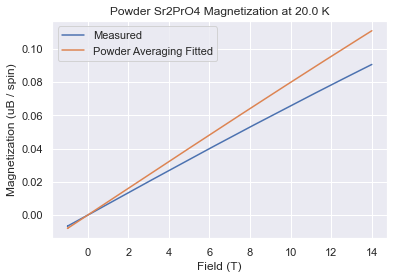

In [31]:
plt.figure()
plt.plot(HTes,MBohr, label = 'Measured')
plt.plot(HTes, fitted.best_fit, label = 'Powder Averaging Fitted')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB / spin)')
plt.title('Powder {} Magnetization at {} K'.format(comp,Temp))
plt.legend()
plt.show()

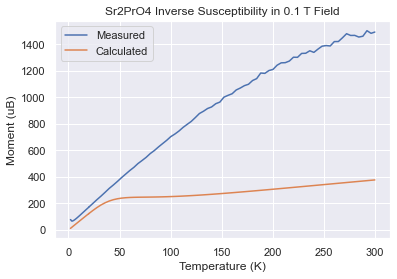

In [37]:
# ## PCF Susceptibility
#####################################################################################################################################################################
MTDir = getSaveDir('m',comp = comp, dataType = 'MT')
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

MTdata = {}
for i in runs:
    M,H,T,Err,samplemass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    M = normalize(M,mass,molweight, 'spin')
    Err = normalize(Err,mass,molweight, 'spin')    
    MTdata[measType] = [M,H,T,Err,samplemass]
    # plt.errorbar(H,M, yerr = Err, label = name)

M,H,T,Err,samplemass = MTdata['FC']

MBohr = emuToBohr2(M)
HTes = oeToTesla(H)
X = MBohr/HTes
Xi  = 1/X

Xcalc = []
Ha = .1
if LS_on:
    for i in T:
        Xcalc.append(fitted.params['a']*Pr.magnetization(Temp = i, Field = [Ha, 0, 0])[0] + fitted.params['a']*Pr.magnetization(Temp = i, Field = [0, Ha, 0])[1] + fitted.params['c']*Pr.magnetization(Temp = i, Field = [0, 0, Ha])[2])
else:   
    for i in T:
        Xcalc.append(fitted.params['a']*Pr.magnetization(Temp = i, Field = [Ha, 0, 0], ion = ion)[0] + fitted.params['a']*Pr.magnetization(Temp = i, Field = [0, Ha, 0], ion = ion)[1] + fitted.params['c']*Pr.magnetization(Temp = i, Field = [0, 0, Ha], ion = ion)[2])

Xcalc = -np.array(Xcalc)/Ha
Xicalc = 1/Xcalc
plt.plot(T,Xi, label = 'Measured')
plt.plot(T,Xicalc, label = 'Calculated')
plt.title('{} Inverse Susceptibility in {} T Field'.format(comp,Ha))
plt.xlabel('Temperature (K)')
plt.ylabel('Moment (uB)')
plt.legend()